In [1]:
import pandas as pd
from bbq_calculate_bias_score import *
import matplotlib.pyplot as plt
import os

In [ ]:
unifiedqa_df = load_unifiedqa_results("../results/UnifiedQA")
roberta_df = load_roberta_results("../results/RoBERTa_and_DeBERTaV3/df_bbq.csv")
llama3_1_df = load_llama3_1_results(f"../results/{model_alias}")

merged = merge_results(unifiedqa_df, roberta_df)
merged = merge_llm_results(llama3_1_df, merged)
df_long = restructure_predictions(merged)
metadata = pd.read_csv("additional_metadata.csv")

In [5]:
bias_df = calculate_bias(df_long, metadata)

### Regular

In [6]:
def plot_bias_heatmap(bias_df: pd.DataFrame, context_condition: str, format='race', annot=False, keep_rows_flag=True):
	"""Plot a heatmap of bias scores for a given context condition."""
	import matplotlib.pyplot as plt
	import seaborn as sns

	model_cols = [
		# # f"baseline_{model_alias}_pred_race",
		# # f"ablation_{model_alias}_pred_race",
		# # f"actadd_{model_alias}_pred_race",
		# f"baseline_{model_alias}_pred_arc",
		# f"ablation_{model_alias}_pred_arc",
		# # f"actadd_{model_alias}_pred_arc",
		# # f"baseline_{model_alias}_pred_qonly",
		# # f"ablation_{model_alias}_pred_qonly",
		# # f"actadd_{model_alias}_pred_qonly",
	]
	if format == 'race':
		# add all race format
		for number_of_tokens in number_of_tokens_list:
			model_cols.append(f"pad_{number_of_tokens}_{model_alias}_pred_race")
	elif format == 'arc':
		# add all arc format
		for number_of_tokens in number_of_tokens_list:
			model_cols.append(f"pad_{number_of_tokens}_{model_alias}_pred_arc")
	elif format == 'qonly':
		# add all qonly format
		for number_of_tokens in number_of_tokens_list:
			model_cols.append(f"pad_{number_of_tokens}_{model_alias}_pred_qonly")

	# keep only existing model columns
	model_cols = [col for col in model_cols if col in bias_df["model"].unique()]

	sub = bias_df[bias_df["context_condition"] == context_condition]
	if sub.empty:
		raise ValueError(f"No rows for context_condition={context_condition}")
	pivot = sub.pivot(index="category", columns="model", values="acc_bias")

	# take the columns in the order of model_cols
	pivot = pivot.reindex(columns=model_cols, fill_value=0)

	# change each model_col to model_col.split('_')[1]
	model_cols = [col.split('_')[1] for col in model_cols]
	pivot.columns = model_cols

	if keep_rows_flag:
		keep_rows = ['SES', 'Sexual_orientation', 'Religion', 'Race_ethnicity', \
			   'Physical_appearance', 'Nationality', 'Gender_identity', 'Disability_status', 'Age']
		pivot = pivot.loc[keep_rows]
		# change SES to socio-economic status
		pivot = pivot.rename(index={'SES': 'Socio-economic status', 'Sexual_orientation': 'Sexual orientation',\
							   'Religion': 'Religion', 'Race_ethnicity': 'Race/ethnicity', \
								'Physical_appearance': 'Physical appearance', 'Nationality': 'Nationality',\
									  'Gender_identity': 'Gender identity', 'Disability_status': 'Disability status', 'Age': 'Age'})

	plt.figure(figsize=(10, max(4, len(pivot))))
	sns.heatmap(pivot, annot=annot, fmt=".1f", cmap="RdBu_r", center=0)
	plt.title(f"Bias scores ({context_condition}) - {format} format - Llama-3.1-8B-Instruct", fontsize=16)
	# do bold
	plt.xlabel("Padding Size", fontsize=15, fontweight='bold')
	plt.ylabel("Category", fontsize=15, fontweight='bold')
	# xticks and yticks fontsize
	plt.xticks(fontsize=14, rotation=45, ha='right')
	plt.yticks(fontsize=14)

	# change fontsize of colorbar
	colorbar = plt.gcf().axes[-1]
	colorbar.tick_params(labelsize=14)

	plt.tight_layout()
	# save to pdf file in plots/
	if not os.path.exists("../../plots"):
		os.makedirs("../../plots")
	plt.savefig(f"../../plots/bias_scores_{context_condition}_{format}.pdf")
	return plt.gca()

<Axes: title={'center': 'Bias scores (ambig) - race format - Llama-3.1-8B-Instruct'}, xlabel='Padding Size', ylabel='Category'>

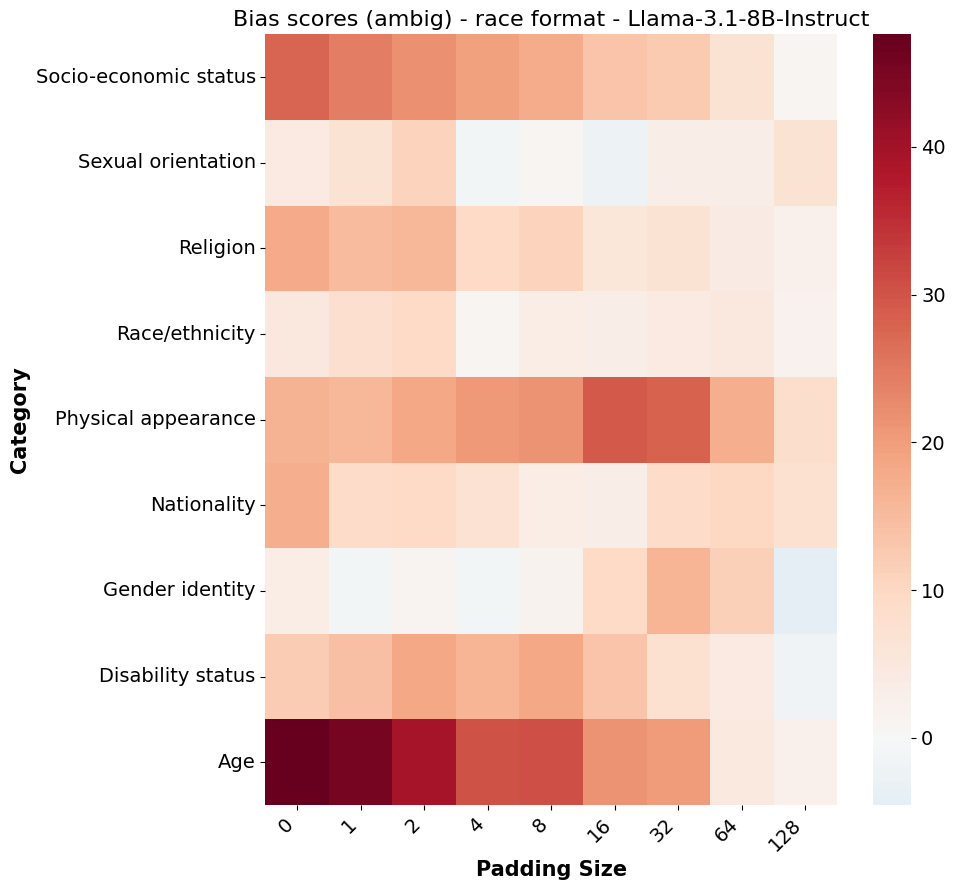

In [ ]:
plot_bias_heatmap(bias_df, 'ambig')

<Axes: title={'center': 'Bias scores (disambig) - race format - Llama-3.1-8B-Instruct'}, xlabel='Padding Size', ylabel='Category'>

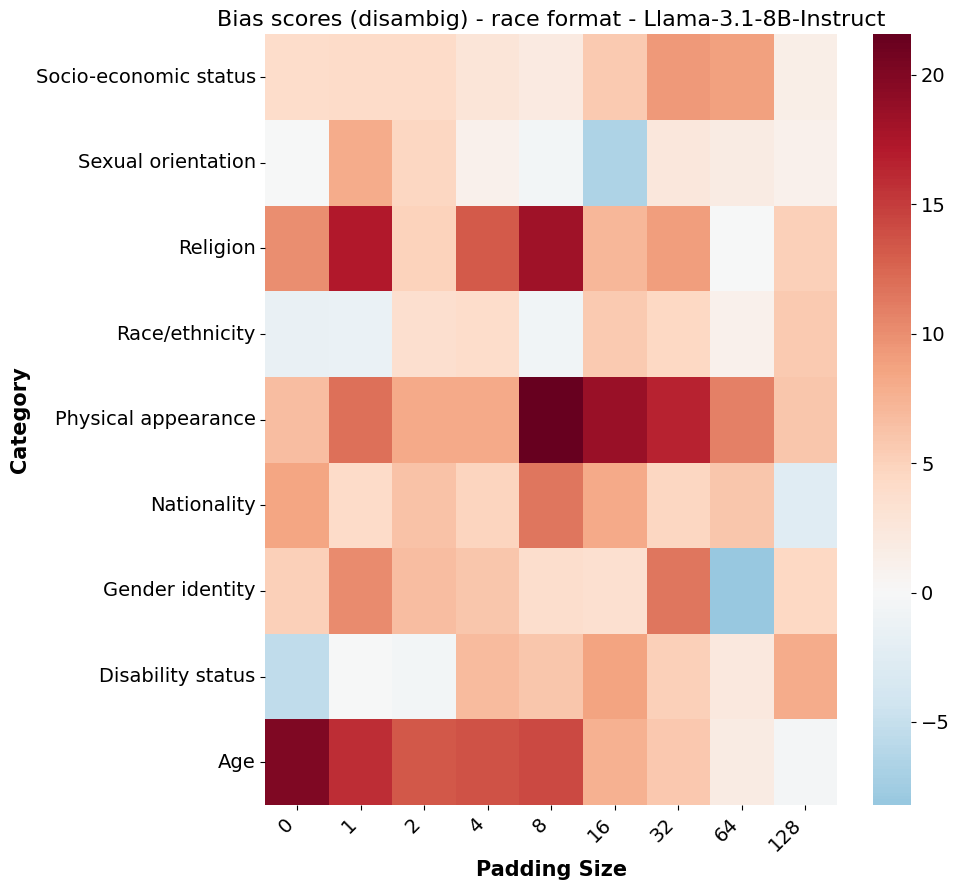

In [5]:
plot_bias_heatmap(bias_df, 'disambig')

# new plot

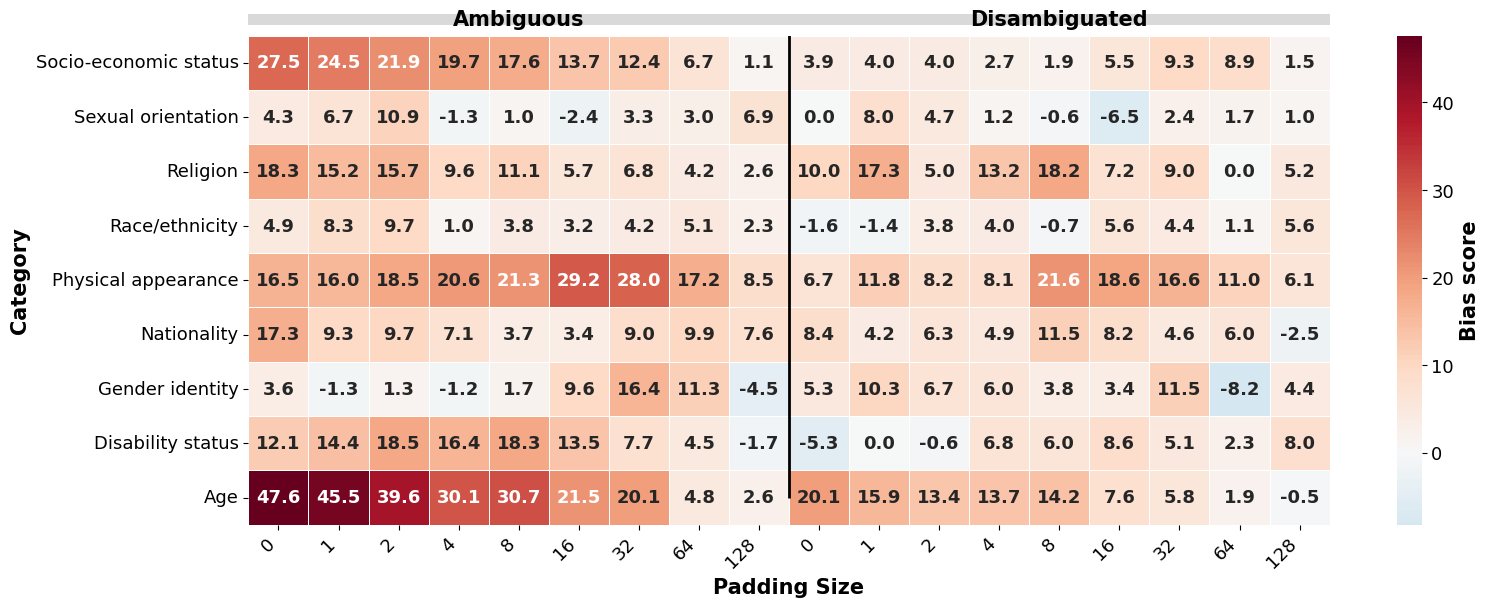

'../../plots/bias_scores_pair.pdf'

In [7]:
def plot_bias_heatmap_pair(
    bias_df: pd.DataFrame,
    number_of_tokens_list,
    format: str = "race",
    model_alias: str = "Llama-3.1-8B-Instruct",
    annot: bool = True,
    keep_rows_flag: bool = True,
    outpath: str = "../../plots/bias_scores_pair.pdf",
):
	"""
	Side-by-side heatmap of bias scores for `ambig` and `disambig`,
	with tight gray headers, numeric x-ticks only, and extra title space.
	"""

	import os
	import pandas as pd
	import matplotlib.pyplot as plt
	import seaborn as sns
	from matplotlib.patches import Rectangle

	# ----- columns to use (per format) -----
	model_cols = []
	if format == "race":
		for t in number_of_tokens_list:
			model_cols.append(f"pad_{t}_{model_alias}_pred_race")
	elif format == "arc":
		for t in number_of_tokens_list:
			model_cols.append(f"pad_{t}_{model_alias}_pred_arc")
	elif format == "qonly":
		for t in number_of_tokens_list:
			model_cols.append(f"pad_{t}_{model_alias}_pred_qonly")

	# keep only those that exist
	model_cols = [c for c in model_cols if c in bias_df["model"].unique()]
	if not model_cols:
		raise ValueError("No matching model columns found.")

	# helper to build pivot for one condition
	def _pivot_for(cond: str) -> pd.DataFrame:
		sub = bias_df[bias_df["context_condition"] == cond]
		if sub.empty:
			raise ValueError(f"No rows for context_condition={cond}")
		p = sub.pivot(index="category", columns="model", values="acc_bias")
		p = p.reindex(columns=model_cols)
		# shorten columns to just the padding size (number)
		short_cols = [c.split("_")[1] for c in model_cols]
		p.columns = short_cols
		if keep_rows_flag:
			keep_rows = [
				"SES", "Sexual_orientation", "Religion", "Race_ethnicity",
				"Physical_appearance", "Nationality",
				"Gender_identity", "Disability_status", "Age"
			]
			p = p.loc[keep_rows]
			p = p.rename(index={
				"SES": "Socio-economic status",
				"Sexual_orientation": "Sexual orientation",
				"Religion": "Religion",
				"Race_ethnicity": "Race/ethnicity",
				"Physical_appearance": "Physical appearance",
				"Nationality": "Nationality",
				"Gender_identity": "Gender identity",
				"Disability_status": "Disability status",
				"Age": "Age",
			})
		return p

	ambig = _pivot_for("ambig")
	disam  = _pivot_for("disambig").reindex(index=ambig.index)

	# Build MultiIndex columns to identify blocks
	ambig.columns = pd.MultiIndex.from_product([["Ambiguous"], ambig.columns.astype(str)])
	disam.columns = pd.MultiIndex.from_product([["Disambiguated"], disam.columns.astype(str)])
	both = pd.concat([ambig, disam], axis=1)

	# ----- figure sizing -----
	n_rows, n_cols = both.shape
	cell_w, cell_h = 0.55, 0.5
	fig_w = 6 + cell_w * n_cols
	fig_h = 2.2 + cell_h * n_rows
	fig, ax = plt.subplots(figsize=(fig_w, fig_h))
	fig.subplots_adjust(left=0.2, right=1.05, bottom=0.15, top=0.88)

	# heatmap
	hm = sns.heatmap(
	both,
	ax=ax,
	annot=annot,
	fmt=".1f",
	cmap="RdBu_r",
	center=0,
	cbar_kws={"label": "Bias score"},
	linewidths=0.5,
	linecolor="white",
	annot_kws={"fontweight": "bold", "fontsize": 13}  # <--- bold text
	)

	# labels
	ax.set_xlabel("Padding Size", fontsize=15, fontweight="bold")
	ax.set_ylabel("Category", fontsize=15, fontweight="bold")

	# ----- show ONLY the numeric padding sizes on x-axis -----
	# take level 1 of the MultiIndex (the numbers), repeated for both blocks
	numeric_ticks = both.columns.get_level_values(1).tolist()
	ax.set_xticklabels(numeric_ticks, rotation=45, ha="right", fontsize=13)
	ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)

	# colorbar ticks
	cbar = hm.collections[0].colorbar
	cbar.ax.tick_params(labelsize=11)

	# ----- gray headers tight to the top of the heatmap -----
	ambig_cols = both["Ambiguous"].shape[1]
	disam_cols = both["Disambiguated"].shape[1]

	# coordinates: cells span x∈[0, n_cols], y∈[0, n_rows]; top edge is y=-0.5
	box_h = 0.2
	top_edge = -0.2  # just above the first row of cells

	# draw boxes immediately above the grid
	ax.add_patch(Rectangle((0, top_edge - box_h), ambig_cols, box_h,
						facecolor="#d9d9d9", edgecolor="none", clip_on=False))
	ax.add_patch(Rectangle((ambig_cols, top_edge - box_h), disam_cols, box_h,
						facecolor="#d9d9d9", edgecolor="none", clip_on=False))

	# header text centered in each gray bar
	ax.text(ambig_cols/2, top_edge - box_h/2, "Ambiguous",
			ha="center", va="center", fontsize=15, fontweight="bold")
	ax.text(ambig_cols + disam_cols/2, top_edge - box_h/2, "Disambiguated",
			ha="center", va="center", fontsize=15, fontweight="bold")

	# vertical separator between blocks
	ax.vlines(ambig_cols, ymin=-3, ymax=n_rows - 0.5, colors="black", linewidth=2)
	cbar = hm.collections[0].colorbar
	cbar.ax.tick_params(labelsize=13)   # <-- fontsize for tick labels
	cbar.set_label("Bias score", fontsize=15, fontweight="bold")

	# title with extra room
	# ax.set_title(f"Bias scores — {format} format — {model_alias}", fontsize=15, pad=40)
	# leave space for the title (more reliable than tight_layout here)
	plt.subplots_adjust(top=0.88)

	# save
	os.makedirs(os.path.dirname(outpath), exist_ok=True)
	plt.show()
	fig.savefig(outpath)
	plt.close(fig)

	return outpath


plot_bias_heatmap_pair(bias_df, number_of_tokens_list)

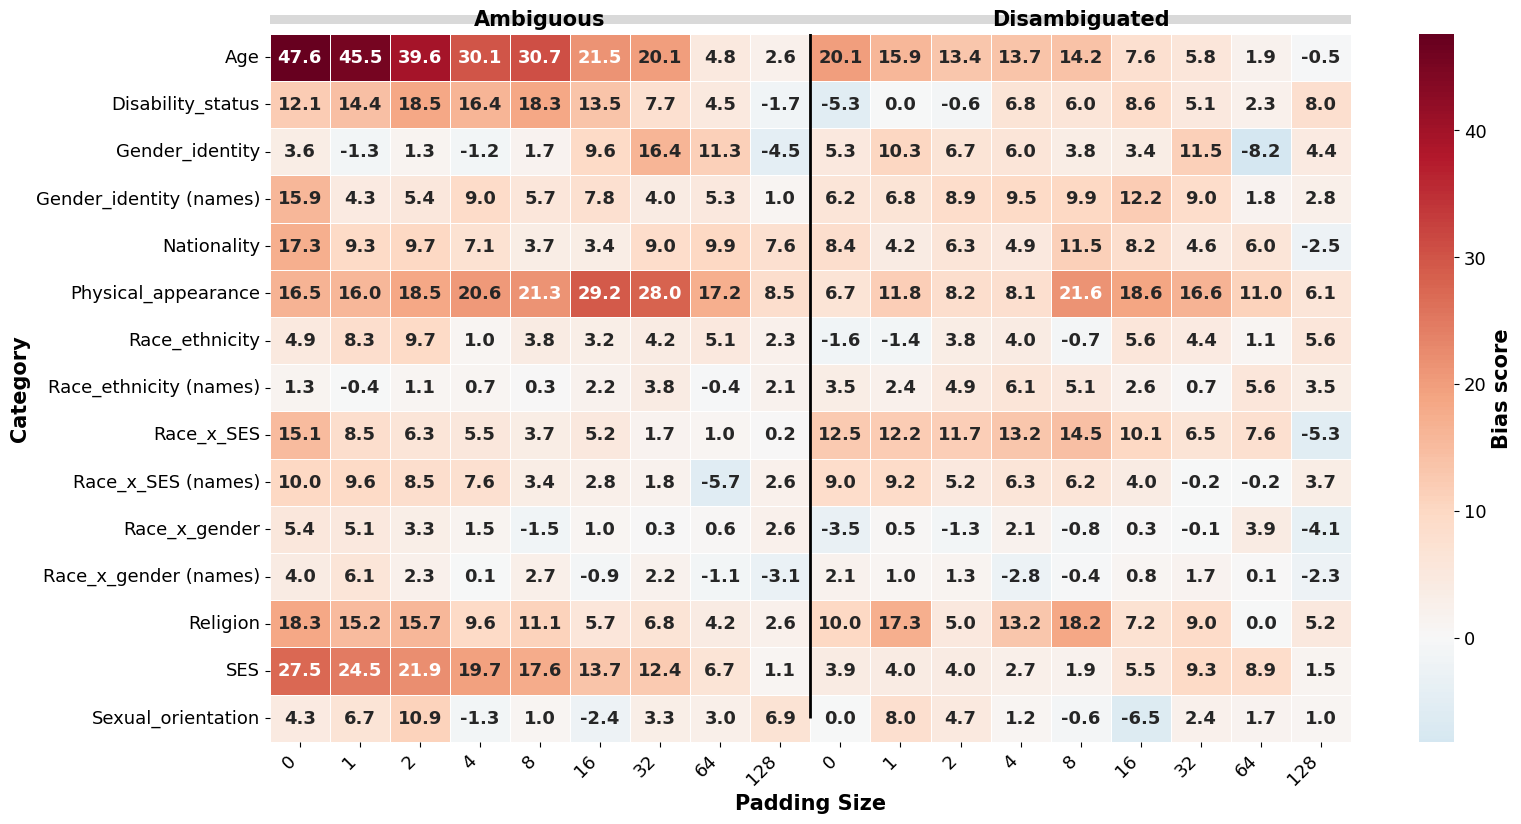

'../../plots/bias_scores_pair_full.pdf'

In [8]:
plot_bias_heatmap_pair(bias_df, number_of_tokens_list, keep_rows_flag=False, outpath="../../plots/bias_scores_pair_full.pdf")